In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

,video_id,transcript
0,AAHiZ-c88ec,man im getting frustrated water heater deliver...
1,AEsRr-ZnzNc,start give shoutout rokukun vyonder harry stac...
2,AJpzk-aFZPU,test number alright okay oh go ground oh god c...
3,AONXX-h9SdI,gonna play something brand new album came octo...
4,AOZIY-AwsjM,music


In [3]:
def get_bow_features(df: pd.DataFrame) -> np.ndarray:
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df["transcript"])
    return X, vectorizer


def get_kmeans_clusters(X: np.ndarray, n_clusters: int = 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    return kmeans


def cluster_transcripts(df: pd.DataFrame, n_clusters: int = 10):
    X, vectorizer = get_bow_features(df)
    kmeans = get_kmeans_clusters(X, n_clusters)
    return kmeans, X, vectorizer

In [4]:
def plot_pca(km, X, title, save=True):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    if save:
        plt.savefig(f"figures/bow_baseline_pca_{title}.png")
    plt.show()


def plot_tsne(km, X, title, save=True):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray())
    plt.figure(figsize=(10, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km.labels_, cmap="plasma", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title(title)
    if save:
        plt.savefig(f"figures/bow_baseline_tsne_{title}.png")
    plt.show()

In [5]:
clusters_sizes = list(range(10, 51))
df_all = df.copy()
df_less_than_100 = df[df["transcript"].str.split().str.len() < 100]
df_more_than_100 = df[df["transcript"].str.split().str.len() >= 100]

df_corporas = [df_all, df_less_than_100, df_more_than_100]
print(df_corporas[0].shape)
print(df_corporas[1].shape)
print(df_corporas[2].shape)

(2630, 2)
(1308, 2)
(1322, 2)


In [6]:
# fit kmeans for each corpus, for each number of clusters
# calculate inertia, silhouette_score, davies_bouldin_score, calinski_harabasz_score for each run
measures = []
measures.append([])  # all
measures.append([])  # less than 100
measures.append([])  # more than 100

km_x_vecs = [[], [], []]  # all, less than 100, more than 100

for n_clusters in tqdm(clusters_sizes):
    for i, df_corpus in enumerate(df_corporas):
        km, X, vectorizer = cluster_transcripts(df_corpus, n_clusters)
        km_x_vecs[i].append((km, X, vectorizer))
        measures[i].append(
            {
                "n_clusters": n_clusters,
                "inertia": km.inertia_,
                "silhouette_score": silhouette_score(X, km.labels_),
                "davies_bouldin_score": davies_bouldin_score(X.toarray(), km.labels_),
                "calinski_harabasz_score": calinski_harabasz_score(
                    X.toarray(), km.labels_
                ),
            }
        )

100%|██████████| 41/41 [04:59<00:00,  7.31s/it]


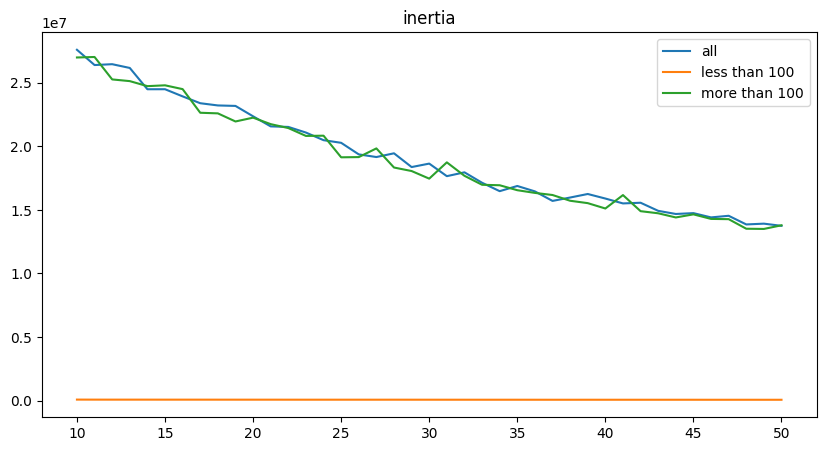

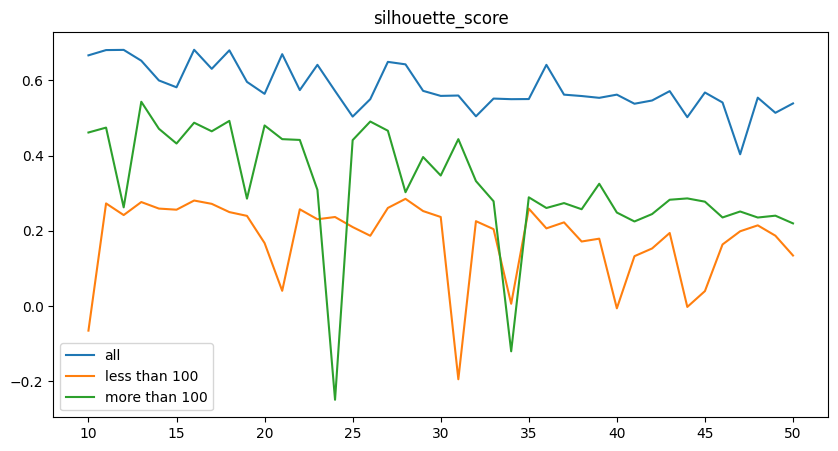

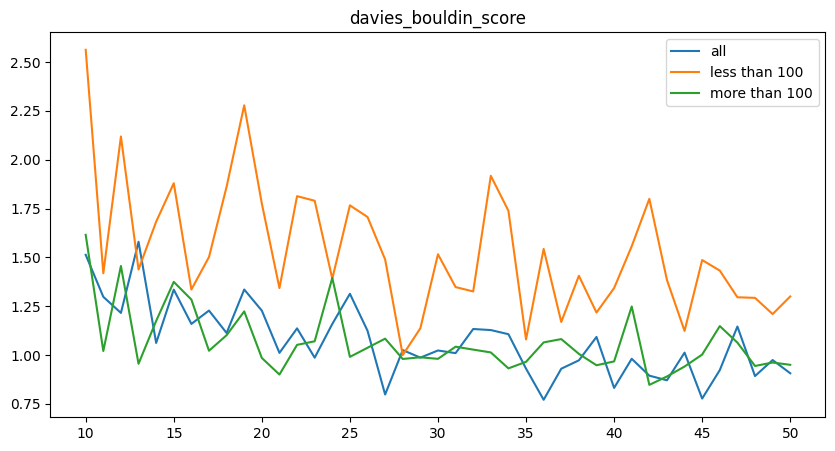

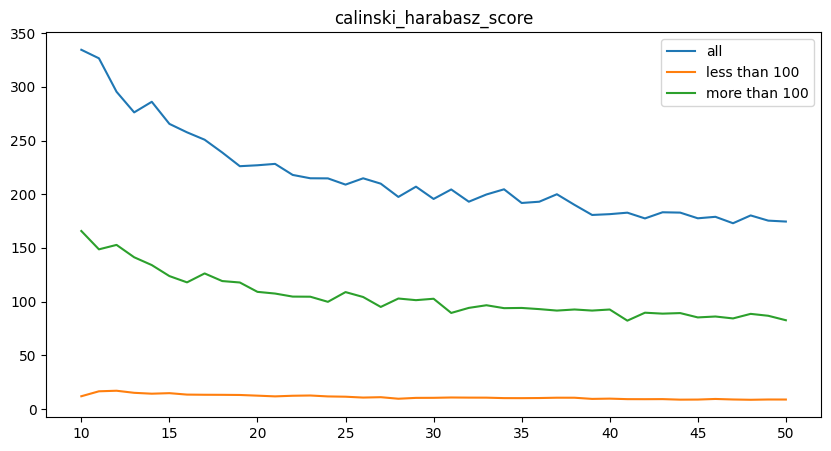

In [7]:
# plot measures for the same corpus, for different number of clusters
plot_attributes = [
    "inertia",
    "silhouette_score",
    "davies_bouldin_score",
    "calinski_harabasz_score",
]
labels = ["all", "less than 100", "more than 100"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    for i, df_corpus in enumerate(df_corporas):
        plt.plot(clusters_sizes, [m[attribute] for m in measures[i]], label=labels[i])
        plt.title(attribute)
    plt.legend()
    plt.savefig(f"../figures/bow_baseline_measure_{attribute}.png")
    plt.show()

# inertia: lower better
# silhouette_score: higher better
# davies_bouldin_score: lower better
# calinski_harabasz_score: higher better

In [8]:
from util import save_topk_words

kms = [km[0] for km in km_x_vecs[0]]
save_topk_words("../topk/bow/bow", df_all, kms, 25, (10, 51, 1), True)

In [10]:
df = df_all
if "word_count" not in df.columns:
    df["word_count"] = df["transcript"].str.split().str.len()

for i in range(0, len(kms), 10):
    labels = kms[i].labels_
    n_clusters = len(set(labels))

    print(f"\nFor k-means with {n_clusters} clusters:")

    for label in range(n_clusters):
        cluster_mask = labels == label
        cluster_lengths = df[cluster_mask]["word_count"]

        print(f"\nCluster {label}:")
        print(f"  Mean length: {cluster_lengths.mean():.1f}")
        print(f"  Median length: {cluster_lengths.median():.1f}")
        print(f"  Min length: {cluster_lengths.min()}")
        print(f"  Max length: {cluster_lengths.max()}")
        print(f"  Size: {len(cluster_lengths)} documents")


For k-means with 10 clusters:

Cluster 0:
  Mean length: 205.3
  Median length: 75.0
  Min length: 1
  Max length: 2283
  Size: 2369 documents

Cluster 1:
  Mean length: 17532.0
  Median length: 17532.0
  Min length: 17532
  Max length: 17532
  Size: 1 documents

Cluster 2:
  Mean length: 16247.7
  Median length: 14567.0
  Min length: 12535
  Max length: 21641
  Size: 3 documents

Cluster 3:
  Mean length: 17956.0
  Median length: 17956.0
  Min length: 17956
  Max length: 17956
  Size: 1 documents

Cluster 4:
  Mean length: 7932.8
  Median length: 7782.0
  Min length: 3508
  Max length: 19397
  Size: 21 documents

Cluster 5:
  Mean length: 3672.0
  Median length: 3672.0
  Min length: 3672
  Max length: 3672
  Size: 1 documents

Cluster 6:
  Mean length: 12895.0
  Median length: 12895.0
  Min length: 12895
  Max length: 12895
  Size: 1 documents

Cluster 7:
  Mean length: 3034.3
  Median length: 3033.5
  Min length: 588
  Max length: 6191
  Size: 64 documents

Cluster 8:
  Mean length:

In [9]:
# for i, km_x_vec in enumerate(km_x_vecs):
#     for j, (k, x, _) in enumerate(km_x_vec):
#         if j % 5 == 0:
#             plot_pca(k, x, f"PCA of {labels[i]} with {clusters_sizes[j]} clusters")
#             # plot_tsne(k, get_bow_features(df_corporas[i]), f"t-SNE of {labels[i]} with {clusters_sizes[j]} clusters")
